In [2]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pdb import set_trace
from copy import copy
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.multitest as multi
import random
from math import log2
import re
import itertools

# Import package to run Enrichr
from gseapy import enrichr

# Import a package to make a volcano plot
from bioinfokit import analys, visuz

In [3]:
# Define a function to import data from an Excel file
def AcessExcelData(FilePath,TabName,ColNamesRow,RowNamesCol,Cols,Rows,NumericData=True):
    # Inputs:
    #   FilePath - full path to the Excel file containing the data
    #   TabName - the tab of the Excel file containing the data
    #   ColNamesRow - The row containing the column names
    #   
    # Outputs:
    #   Quantities - a pandas data frame
    #     rows are named after genes
    #     columns are named after samples
    
    xl = pd.ExcelFile(FilePath)
    quantities = xl.parse(TabName,header=ColNamesRow)
    RowNames = quantities.iloc[Rows,RowNamesCol]
    Quantities = quantities.iloc[Rows,Cols]
    ColumnNames = Quantities.columns
    Quantities.index = RowNames.astype('str')
    
    # drop the column that contained the row names after the rows are named
    Quantities = Quantities.drop(ColumnNames[RowNamesCol],axis=1)   
    ColnmnNames = np.asarray(ColumnNames)
    ColumnNames = ColumnNames[ColumnNames!=ColumnNames[RowNamesCol]]
    
    # Remove the duplicate rownames
    #   Keeps the first instance of a duplicated rowname
    Quantities = Quantities[~Quantities.index.duplicated(keep='first')]
    if NumericData:
        for col_name in ColumnNames:
            Quantities.loc[:,col_name] = pd.to_numeric(Quantities.loc[:,col_name])
    return Quantities

In [4]:
# Open BC Proteome Data

# Open the Excel file containing the protein exression data
BC_Proteomics = '/Users/heesoojeong/Dropbox/Heesoo/PC_paper/Fig4/Distance_Metric_Density_and_GDF_File_Creation/BC_Proteomics.xlsx'
xl = pd.ExcelFile(BC_Proteomics)

# Open the desired tab of the Excel file as a data frame
quantities = xl.parse('1 Prot FDR 9995 quant')

# Extract the gene names from the Excel file
gene_names = quantities.iloc[:,0][2:9997]

# Extract the protein expression data from the excel file
BC_proteome = quantities.iloc[2:9997,34:79]

# Convert the data to a type numeric
#   Note, this is an annoying step that is hard to determine that it needs to be done
#   The red flag was that plotting commands give errors when passed this data frame without conversion
col_names = BC_proteome.columns
for col_name in col_names:
    BC_proteome.loc[:,col_name] = pd.to_numeric(BC_proteome.loc[:,col_name])

BC_proteome = np.log2(BC_proteome)
BC_proteome.index = gene_names
BC_proteome_Corr_Matrix = BC_proteome.transpose().corr()

In [5]:
# Define the imputs for importing a data file
FilePath = '/Users/heesoojeong/Dropbox/Heesoo/PC_paper/Fig4/Distance_Metric_Density_and_GDF_File_Creation/DATA_rotenone_over_control_log2.xlsx'
TabName = 'DATA'
ColNamesRow = 0
RowNamesCol = 0
Cols = np.arange(0,6)
Rows = np.arange(0,9827)

# Import the data and transpose to have genes naming the columns
Quantities = AcessExcelData(FilePath=FilePath,
                            TabName=TabName,
                            ColNamesRow=ColNamesRow,
                            RowNamesCol=RowNamesCol,
                            Cols=Cols,
                            Rows=Rows)

n_genes = len(Quantities.index)-6
Gene_Values = Quantities.iloc[np.arange(0,n_genes),:]
n_samples = len(Gene_Values.columns)
gene_names = np.asarray(Gene_Values.index)
Gene_Flux_Cor_Matrix = Quantities.transpose().corr()
Rand_Quantities = copy(Quantities)

In [6]:
# Functions to get the correlation distance between a gene, and the top correlating gene of that gene in another data set, in the data set of interest 
def Parallel_Set_Distance(gene,Cor_Matrix1,Cor_Matrix2,flux):
    GeneSet1 = np.asarray(Cor_Matrix1.columns)
    GeneSet2 = np.asarray(Cor_Matrix2.columns)
    
    extreme_type = 'max'
    if Cor_Matrix1.loc[flux,gene] < 0:
        extreme_type = 'min'
    
    top_cor_gene_array = ExtremeCorr(CorMatrix=Cor_Matrix1,gene=gene,extreme=extreme_type)[3]
    
    GeneInSet2 = gene in GeneSet2
    i = 0
    while not GeneInSet2:
        gene = top_cor_gene_array[i]
        GeneInSet2 = gene in GeneSet2
        i = i+1
    
    top_cor_gene = ExtremeCorr(CorMatrix=Cor_Matrix2,gene=gene,extreme=extreme_type)[0]
    top_cor_gene_top_cor_array = ExtremeCorr(CorMatrix=Cor_Matrix2,gene=top_cor_gene,extreme=extreme_type)[3]
    top_cor_gene_top_cor_array = top_cor_gene_top_cor_array[top_cor_gene_top_cor_array != gene]
    
    TopGeneInSet1 = top_cor_gene in GeneSet1
    i = 0
    while not TopGeneInSet1:
        top_cor_gene = top_cor_gene_top_cor_array[i]
        TopGeneInSet1 = top_cor_gene in GeneSet1
        i = i+1
    
    parallel_set_correlation = Cor_Matrix1.loc[gene,top_cor_gene]
    parallel_set_correlation_distance = (1-parallel_set_correlation)/2
    
    return(parallel_set_correlation_distance)
    
def ExtremeCorr(CorMatrix,gene,extreme):
    ArrayToQuerry = CorMatrix.loc[gene,][CorMatrix.loc[gene,]!=1]
    if extreme == 'max':
        extreme_cor_index = np.argmax(ArrayToQuerry)
        extreme_cor_gene = ArrayToQuerry.index[extreme_cor_index]
        extreme_cor = np.max(ArrayToQuerry)
        extreme_cor_gene_array = np.asarray(CorMatrix.loc[gene,].sort_values(ascending=False).index)
    
    if extreme == 'min':
        extreme_cor_index = np.argmin(ArrayToQuerry)
        extreme_cor_gene = ArrayToQuerry.index[extreme_cor_index]
        extreme_cor = np.min(ArrayToQuerry)
        extreme_cor_gene_array = np.asarray(CorMatrix.loc[gene,].sort_values(ascending=True).index)
    
    extreme_cor_dist = (1-extreme_cor)/2
    
    ECR = [extreme_cor_gene,extreme_cor,extreme_cor_dist,extreme_cor_gene_array]
    
    return(ECR)

In [7]:
#Function to compute random correlations
def RandomGeoDist(rand1,rand2):

    cor = np.corrcoef(rand1,rand2)[0,1]
    CorD = (1-cor)/2
    
    EucD = np.linalg.norm(rand1 - rand2)
    
    return([cor,CorD,EucD])

In [8]:
Fluxes = ['Growth','UglnM5citrate591','PCFlux','UGlcM3Serine390','UGlcM2Citrate591','UGlnM4Malate419']

n_random_correlations = 10000

FluxCorDict = dict()
EuclideanNormDict = dict()
CorDistDict = dict()
GeoDistDict = dict()
ParSetCorDist = dict()
LinAvgDist = dict()
LinAvgDist2 = dict()
LinAvgDist3 = dict()

for flux in Fluxes:
    print(flux)
    flux_values = Quantities.loc[flux,]
    
    # vector of each gene's correlations to the current flux
    flux_Correlations = [np.corrcoef(flux_values,Gene_Values.iloc[i,])[0,1] for i in np.arange(0,n_genes)]
    
    # vector of correlations converted to distances
    flux_Cor_Dist = 0.5*(1-np.asarray(flux_Correlations))
    
    # vector of correlation distances between genes in this set and their most highly correlated gene in another set
    print('Calculating parallel set gene correlations.')
    parallel_set_cor_dist = [Parallel_Set_Distance(gene = gene_names[i],
                                                   Cor_Matrix1 = Gene_Flux_Cor_Matrix,
                                                   Cor_Matrix2 = BC_proteome_Corr_Matrix,
                                                   flux = flux) 
                                                   for i in np.arange(0,n_genes)]
    print('Finished calculating parallel set gene correlations.')
    
    # vector euclidean distances of the current flux to each gene 
    flux_Euclidean = [np.linalg.norm(flux_values - Gene_Values.iloc[i,]) for i in np.arange(0,n_genes)]
    
    # euclidean distances normalized to the 95th percentile of euclidean distances to place most between 0 and 1
    flux_Euclidean_Norm = flux_Euclidean/np.percentile(flux_Euclidean,95)
    
    # Geometric distance of normalized euclidean distance and correlation distance
    Geometric_dist = (flux_Euclidean_Norm**2+flux_Cor_Dist**2)**0.5
    Lin_Avg_dist = (flux_Cor_Dist + parallel_set_cor_dist)/2
    Lin_Avg_dist_2 = (flux_Cor_Dist + parallel_set_cor_dist + flux_Euclidean_Norm)/3
    Lin_Avg_dist_3 = 0.25*flux_Cor_Dist + 0.75*np.asarray(parallel_set_cor_dist)
    
    FluxCorDict[flux] = flux_Correlations
    EuclideanNormDict[flux] = flux_Euclidean_Norm
    CorDistDict[flux] = flux_Cor_Dist
    GeoDistDict[flux] = Geometric_dist
    ParSetCorDist[flux] = parallel_set_cor_dist
    LinAvgDist[flux] = Lin_Avg_dist
    LinAvgDist2[flux] = Lin_Avg_dist_2
    LinAvgDist3[flux] = Lin_Avg_dist_3

# initialize as np arrays of floats
Cor_Shuffled = np.repeat(1.1,n_random_correlations)
CorD_Shuffled = np.repeat(1.1,n_random_correlations)
EucD_Shuffled = np.repeat(1.1,n_random_correlations)
Parallel_Set_CorD_Random = np.repeat(1.1,n_random_correlations)

for i in np.arange(0,n_random_correlations):
    if i%10000==0:
        print('gene ' + str(i))

    selected_flux_index = np.random.choice(np.arange(0,len(Fluxes)))
    selected_flux_index = 1
    selected_flux = Fluxes[selected_flux_index]

    
    selected_gene_index = np.random.choice(np.arange(0,len(gene_names)))
    selected_gene = gene_names[selected_gene_index]
    selected_gene_vector = Quantities.loc[selected_gene,]                  
    selected_gene_mean = np.mean(selected_gene_vector)
    selected_gene_sd = np.std(selected_gene_vector)
    
    selected_gene_index_2 = np.random.choice(np.arange(0,len(gene_names)))
    selected_gene_2 = gene_names[selected_gene_index_2]
    selected_gene_vector_2 = Quantities.loc[selected_gene_2,]                  
    selected_gene_mean_2 = np.mean(selected_gene_vector_2)
    selected_gene_sd_2 = np.std(selected_gene_vector_2)
        
    #need to do this for every flux...    
    rand1 = Quantities.loc[selected_flux,]
    rand2 = np.random.normal(loc=selected_gene_mean,scale=selected_gene_sd,size=(1,5))[0]
    rand3 = np.random.normal(loc=selected_gene_mean_2,scale=selected_gene_sd_2,size=(1,5))[0]
    
    RGDR = RandomGeoDist(rand1,rand2)
    Cor_Shuffled[i] = RGDR[0]
    CorD_Shuffled[i] = RGDR[1]
    EucD_Shuffled[i] = RGDR[2]
    
    RGDR2 = RandomGeoDist(rand2,rand3)
    Parallel_Set_CorD_Random[i] = RGDR2[1]
    
Geo_D_Shuffled = (CorD_Shuffled**2 + EucD_Shuffled**2)**0.5 
EucD_Shuffled_Norm = EucD_Shuffled/np.percentile(EucD_Shuffled,95)

GeoD_Shuffled = (CorD_Shuffled**2+EucD_Shuffled_Norm**2)**0.5
LinAvg_D_Shuffled = (CorD_Shuffled + Parallel_Set_CorD_Random)/2
LinAvg_D_Shuffled_2 = (CorD_Shuffled + Parallel_Set_CorD_Random + EucD_Shuffled_Norm)/3
LinAvg_D_Shuffled_3 = 0.25*CorD_Shuffled + 0.75*np.asarray(Parallel_Set_CorD_Random)


Growth
Calculating parallel set gene correlations.
Finished calculating parallel set gene correlations.
UglnM5citrate591
Calculating parallel set gene correlations.
Finished calculating parallel set gene correlations.
PCFlux
Calculating parallel set gene correlations.
Finished calculating parallel set gene correlations.
UGlcM3Serine390
Calculating parallel set gene correlations.
Finished calculating parallel set gene correlations.
UGlcM2Citrate591
Calculating parallel set gene correlations.
Finished calculating parallel set gene correlations.
UGlnM4Malate419
Calculating parallel set gene correlations.
Finished calculating parallel set gene correlations.
gene 0


In [9]:
# Create long data frame
Geo_D_Value = np.array([])
Geo_D_Type = np.array([])
Gene_Name_Array = np.array([])

Cor_D_Value = np.array([])
Euc_D_Value_Norm = np.array([])
LinAvg_D_Value = np.array([])
LinAvg_D_Value_2 = np.array([])
LinAvg_D_Value_3 = np.array([])

FluxesToPlot = Fluxes
palette = {'UglnM5citrate591':'#20639b',
           'PCFlux':'#173f5f',
           'UGlcM3Serine390':'#3caea3',
           'UGlcM2Citrate591':'#B23BFF',
           'UGlnM4Malate419':'#ed553b',
           'Growth':'green',
           'decoy':'red'}

Geo_D_Value = np.concatenate((Geo_D_Value,GeoD_Shuffled))
Geo_D_Type = np.concatenate((Geo_D_Type,np.repeat('decoy',n_random_correlations)))
Gene_Name_Array = np.repeat('none',n_random_correlations)

Cor_D_Value = np.concatenate((Cor_D_Value,CorD_Shuffled))
Euc_D_Value_Norm = np.concatenate((Euc_D_Value_Norm,EucD_Shuffled_Norm))
LinAvg_D_Value = np.concatenate((LinAvg_D_Value,LinAvg_D_Shuffled))
LinAvg_D_Value_2 = np.concatenate((LinAvg_D_Value_2,LinAvg_D_Shuffled_2))
LinAvg_D_Value_3 = np.concatenate((LinAvg_D_Value_3,LinAvg_D_Shuffled_3))

for flux in FluxesToPlot:
    Geo_D_Value = np.concatenate((Geo_D_Value,GeoDistDict[flux]))
    Geo_D_Type = np.concatenate((Geo_D_Type,np.repeat(flux,n_genes)))
    Gene_Name_Array = np.concatenate((Gene_Name_Array,gene_names))
    
    Cor_D_Value = np.concatenate((Cor_D_Value,CorDistDict[flux]))
    Euc_D_Value_Norm = np.concatenate((Euc_D_Value_Norm,EuclideanNormDict[flux]))
    LinAvg_D_Value = np.concatenate((LinAvg_D_Value,LinAvgDist[flux]))
    LinAvg_D_Value_2 = np.concatenate((LinAvg_D_Value_2,LinAvgDist2[flux]))
    LinAvg_D_Value_3 = np.concatenate((LinAvg_D_Value_3,LinAvgDist3[flux]))

PCFluxGeoLongDF = pd.DataFrame()
PCFluxGeoLongDF.loc[:,'GeoD'] = Geo_D_Value
PCFluxGeoLongDF.loc[:,'GeoDType'] = Geo_D_Type
PCFluxGeoLongDF.loc[:,'CorD'] = Cor_D_Value
PCFluxGeoLongDF.loc[:,'EucD_Norm'] = Euc_D_Value_Norm
PCFluxGeoLongDF.loc[:,'LinAvgD'] = LinAvg_D_Value
PCFluxGeoLongDF.loc[:,'LinAvgD2'] = LinAvg_D_Value_2
PCFluxGeoLongDF.loc[:,'LinAvgD3'] = LinAvg_D_Value_3
PCFluxGeoLongDF.loc[:,'Gene']= Gene_Name_Array

In [14]:
# Create a data frame with three columns (GeoDType, LinAvg Distance, and Gene).
## GeoDType is renamed to Flux
Flux_Protein_Distance_DF = copy(PCFluxGeoLongDF)
Flux_Protein_Distance_DF = Flux_Protein_Distance_DF.rename(columns={'GeoDType': "Flux"})
Flux_Protein_Distance_DF = Flux_Protein_Distance_DF.loc[:,np.array(['Flux','LinAvgD','Gene'])]
Flux_Protein_Distance_DF

In [11]:
# A function for gene set enrichment analysis (GSEA) on a block of 100 genes (except for decoy)
def EnrichDF(long_df, GeoDType):
    #make a data frame for each flux(GeoDType)
    flux_df = long_df.loc[long_df.loc[:,'Flux']==GeoDType,:]
    #sort by distance and reset index
    flux_df = flux_df.sort_values('LinAvgD')
    flux_df = flux_df.reset_index(drop=True)
    
    # Do enrich analysis
    ## if there are 9821 genes, one block should have 121 genes. Other blocks have 100 genes.
    n_genes = len(flux_df)
    if (n_genes % 100) != 0:
        n_groups = n_genes // 100
        n_groups_middle = n_groups / 2
        index_121_starts = int(n_groups_middle*100)
        index_121_ends = int(index_121_starts + 100 + (n_genes%100) - 1)
        n_genes_middle_group = index_121_ends - index_121_starts + 1
    
        for i in np.arange(0,(n_genes+1)):
            genes = np.asarray(flux_df.loc[:,'Gene'])
            if (i != 0) & (i % 100 == 0) & (i <= index_121_starts):
                indices = np.arange(i-100,i)
                #genes = np.asarray(PCFlux_Protein_Distance_DF.loc[:,'Gene'])
                genes = genes[indices]
                genes_list = genes.tolist()
                Enrichment = enrichr(gene_list=genes_list, gene_sets='KEGG_2016', outdir='test', cutoff=1)
                LeadingP = Enrichment.results.iloc[0,4]
                LeadingP_Array = np.repeat(LeadingP,100)
                flux_df.loc[indices,'EnrichP'] = LeadingP_Array
                
            if i == (index_121_ends + 1):
                indices = np.arange(i - n_genes_middle_group,i)
                #genes = np.asarray(PCFlux_Protein_Distance_DF.loc[:,'Gene'])
                genes = genes[indices]
                genes_list = genes.tolist()
                Enrichment = enrichr(gene_list=genes_list, gene_sets='KEGG_2016', outdir='test', cutoff=1)
                LeadingP = Enrichment.results.iloc[0,4]
                LeadingP_Array = np.repeat(LeadingP,n_genes_middle_group)
                flux_df.loc[indices,'EnrichP'] = LeadingP_Array
                
            if (i >= (index_121_ends+100)) & (i % 100 == (n_genes%100)):
                indices = np.arange(i-100,i)
                genes = genes[indices]
                genes_list = genes.tolist()
                Enrichment = enrichr(gene_list=genes_list, gene_sets='KEGG_2016', outdir='test', cutoff=1)
                LeadingP = Enrichment.results.iloc[0,4]
                LeadingP_Array = np.repeat(LeadingP,100)
                flux_df.loc[indices,'EnrichP'] = LeadingP_Array
    return(flux_df)

# A function adjusting distances using p-values from the GSEA
def Adjust_Distance(df):
    n_genes = len(df)
    for i in np.arange(0, n_genes):
        linearD = df["LinAvgD"].iloc[i]
        enrichp = df["EnrichP"].iloc[i]
        adjustment = (0.5-linearD) * enrichp
        adjustD = linearD + adjustment
        df.loc[i, "AdjustedD"] = adjustD
    return(df)

In [23]:
# Do GSEA for each GeoDType
## After GSEA, output returns a dataframe only containing results for each metabolic flux so that it can be directly used to make a histogram
PCFlux_D_DF = EnrichDF(Flux_Protein_Distance_DF, "PCFlux")
QOX_D_DF = EnrichDF(Flux_Protein_Distance_DF, "UGlnM4Malate419")
QRC_D_DF = EnrichDF(Flux_Protein_Distance_DF, "UglnM5citrate591")
Ser_D_DF = EnrichDF(Flux_Protein_Distance_DF, "UGlcM3Serine390")
PDH_D_DF = EnrichDF(Flux_Protein_Distance_DF, "UGlcM2Citrate591")
Growth_D_DF = EnrichDF(Flux_Protein_Distance_DF, "Growth")

# Adjust distance with p-value from GSEA
PCFlux_D_DF = Adjust_Distance(PCFlux_D_DF)
QOX_D_DF = Adjust_Distance(QOX_D_DF)
QRC_D_DF = Adjust_Distance(QRC_D_DF)
Ser_D_DF = Adjust_Distance(Ser_D_DF)
PDH_D_DF = Adjust_Distance(PDH_D_DF)
Growth_D_DF = Adjust_Distance(Growth_D_DF)



In [21]:
# GSEA for the decoy data frame
## 100 genes are randomly selected from a list of genes (from BC data set) and the list were put into GSEA
## The smallest p-value was taken from GSEA and used for the adjustment

### Make a data frame with decoy, the LinAvg Distance, and the Gene name
Decoy_Protein_Distance_DF = Flux_Protein_Distance_DF.loc[Flux_Protein_Distance_DF.loc[:,'Flux']=='decoy',:]
Decoy_Protein_Distance_DF = Decoy_Protein_Distance_DF.rename(columns={'GeoDType': "Flux"})
### Sort according to the LinAvgD values
Decoy_Protein_Distance_DF = Decoy_Protein_Distance_DF.sort_values('LinAvgD')
### Reset row index in the decoy data frame
Decoy_Protein_Distance_DF = Decoy_Protein_Distance_DF.reset_index(drop=True)

### Make a list to store 10,000 p-values
MoreP = []
### Put gene names in an array (a list where 100 genes will be randomly selected)
genes = np.asarray(PCFlux_D_DF.loc[:,'Gene'])

### Collect 10,000 p-values
### For loop to draw p values from the gene list. Randomly select 100 genes from the list "genes", do GSEA, record a p valuee, and put it in MoreP list.
for i in range(0,10000):
    random_genes = random.choices(genes, k = 100)
    Enrichment = enrichr(gene_list=random_genes, gene_sets='KEGG_2016', outdir='test', cutoff=1)
    LeadingP = Enrichment.results.iloc[0,4]
    MoreP.append(LeadingP)
    
### Store the 10,000 p-values
with open(r'/Users/heesoojeong/Dropbox/Heesoo/PC_paper/Fig4/Distance_Metric_Density_and_GDF_File_Creation/Decoy_Pvalues.txt', 'w') as writefile:
    for item in MoreP:
        writefile.write("%s\n" % item) #write a p-value in each line

In [624]:
# Getting a distribution of the 10,000 p-values for the decoy data frame
## As certain p-values can appear more than once, calculate probabilities for each p-value
## Using the distribution of the 10,000 p-values, draw a p-value for each decoy distance 

### Check if there are p-values appearing more than once in the list of 10,000 p-values
import sys #this is to print all items in an array
value, counts = np.unique(MoreP, return_counts=True) #check if there are p-values appearing more than once
np.set_printoptions(threshold=sys.maxsize) #this is to print all items in an array so that we import all p-values in the list

### Make a list where p-values and corresponding probabilities will be stored
P_list = [] # a list of p-values
P_prob_list = [] # a list of probabilites for each p-value
### Fill in the two lists (P_list and P_prob_list) with p-values and corresponding probabilities.
for i in range(0, len(value)):
    pval = value[i]
    P_list.append(pval)
    prob = counts[i]/sum(counts)
    P_prob_list.append(prob)

### Draw a p-value for each row in the decoy data frame using the lists P-list and P_prob_list. 
### Put p-values in the column called EnrichP.
for i in range(0, len(Decoy_Protein_Distance_DF.index)):
    pval_random = random.choices(P_list, weights = P_prob_list, k=1)
    Decoy_Protein_Distance_DF.loc[i,'EnrichP'] = pval_random[0]

### Using the p-values, adjust distances 
Decoy_Protein_Distance_DF = Adjust_Distance(Decoy_Protein_Distance_DF)

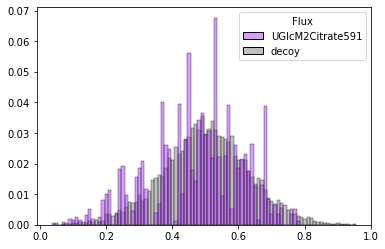

In [55]:
# Make a histogram showing adjusted distances of PC flux and Decoy data frames

## A data frame putting PC flux and Decoy distances together
adjustD_long_df = pd.concat([PCFlux_D_DF, Decoy_Protein_Distance_DF], join = "inner")
adjustD_long_df = adjustD_long_df.reset_index(drop=True) 

palette = {'UglnM5citrate591':'#20639b',
           'PCFlux':'#02075D',
           'UGlcM3Serine390':'#3caea3',
           'UGlcM2Citrate591':'#B23BFF',
           'UGlnM4Malate419':'#ed553b',
           'Growth':'green',
           'decoy':'grey'}

p = sns.histplot(data=adjustD_long_df,
                x='AdjustedD',
                hue='Flux',
                #kind="kde", 
                #bw_adjust=0.5, 
                fill=True, 
                #height=4, 
                #aspect=3/3, 
                #alpha=0.5,
                #linewidth = 0,
                common_norm=False,
                #cut=0
                binwidth = 0.01,
                stat = 'probability',
                palette = palette,
                #cumulative = True
               )
p.set(#xlim=(0, x_max),
      #ylim=(0,0.03),
      xlabel='',
      ylabel='')

plt.tick_params(axis='both', which='major', labelsize=10)

plt.savefig('/Users/heesoojeong/Dropbox/Heesoo/PC_paper/Fig4/density_plots/Probability/PC.pdf')

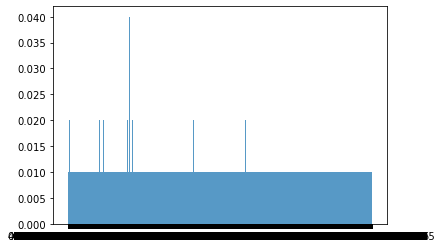

In [42]:
# Make a histogram with 10,000 values of decoy p-values
p = sns.histplot(data=decoy_p_list,
                #x='AdjustedD',
                #hue='Flux',
                #kind="kde", 
                #bw_adjust=0.5, 
                fill=True, 
                #height=4, 
                #aspect=3/3, 
                #alpha=0.5,
                #linewidth = 0,
                common_norm=False,
                #cut=0
                bins = 20,
                stat = 'percent',
                #palette = palette,
                #cumulative = True
               )
p.set(#xlim=(0, x_max),
      #ylim=(0,0.03),
      xlabel='',
      ylabel='')

plt.tick_params(axis='both', which='major', labelsize=10)

#plt.savefig('/Users/heesoojeong/Dropbox/Heesoo/PC_paper/9thDraft_2023-04-01/decoy/decoy_hist.pdf')

In [25]:
# Define nodes and edges for network analysis. Make a gdf file for gephi
# Using a criteria of distance < 0.125, define nodes for network analysis
## A long data frame containing correlation of proteins and all metabolic fluxes
node_df = pd.concat([QOX_D_DF, QRC_D_DF, PCFlux_D_DF, Ser_D_DF, PDH_D_DF, Growth_D_DF], join = "inner")
node_df = node_df.reset_index(drop=True)

## Make a column defining node colors (color for each metabolic flux)
palette = {'UglnM5citrate591':'#20639b',
           'PCFlux':'#02075D',
           'UGlcM3Serine390':'#3caea3',
           'UGlcM2Citrate591':'#B23BFF',
           'UGlnM4Malate419':'#ed553b',
           'Growth':'green',
           'decoy':'grey'}

for key in palette:
    for i in range(0, len(node_df)):
        flux = node_df['Flux'].iloc[i]
        if key == flux:
            color = palette[key]
            node_df.loc[i, 'NodeColor'] = color

## Filter proteins not meeting the criteria (distance < 0.125)
### a list of proteins not meeting the criteria
rows_to_delete = [] 
### for loop to filter the proteins
for i in range(0, len(node_df)):
    D = node_df['AdjustedD'].iloc[i]
    if (D>0.125):
        rows_to_delete.append(i)
### delete proteins not meeting the criteria
node_df = node_df.drop(rows_to_delete)

###################################################
# Define edges
## A data frame of protein-protein correlations
Gene_Cor_df = copy(Gene_Flux_Cor_Matrix)
Fluxes = ['Growth','UglnM5citrate591','PCFlux','UGlcM3Serine390','UGlcM2Citrate591','UGlnM4Malate419']
Gene_Cor_df = Gene_Cor_df.drop(Fluxes, axis=1) #delete columns with flux names
Gene_Cor_df = Gene_Cor_df.drop(Fluxes) #delete rows with flux names

## Make a list of proteins that are defined as nodes
### This step is to avoid defining edges multiple times as some proteins are defined as regulators for more than one metabolic flux.
gene_in_nodes = node_df['Gene'].to_numpy()
unique_nodes = np.unique(gene_in_nodes)
unique_nodes = unique_nodes.tolist()
## In the data frame of protein-protein correlations, leave proteins that are defined as nodes
Gene_Cor_df = Gene_Cor_df.drop(columns=[col for col in Gene_Cor_df if col not in unique_nodes])                
Gene_Cor_df = Gene_Cor_df[Gene_Cor_df.index.isin(unique_nodes)]

## Make a gdf file defining nodes and edges for gephi
gdf_new_path = '/Users/heesoojeong/Dropbox/Heesoo/PC_paper/Fig4/gephi/adjust_cor/nodesedges_0118_0.96.gdf'
### Iterate through column and write into edges.
with open(gdf_new_path,'w') as gdf_new_file:
    gdf_new_file.write('nodedef> name VARCHAR,label VARCHAR,color VARCHAR\n')
    for i in range(0, len(node_df)):
        gene = node_df['Gene'].iloc[i]
        color = node_df['NodeColor'].iloc[i]
        gdf_new_file.write(gene+','+'\"'+gene+'\"'+','+color+'\n')
        
    gdf_new_file.write('edgedef> node1,node2,weight DOUBLE,directed BOOLEAN\n')    
    for i in range(0, len(Gene_Cor_df)):
        cor_list = Gene_Cor_df.iloc[:,i]
        for l in range(i, len(cor_list)):
            cor = cor_list[l]
            if (cor>0.96) & (cor != 1):
                row_gene = list(Gene_Cor_df.index)[l]
                column_gene = list(Gene_Cor_df.columns)[i]
                gdf_new_file.write(column_gene+','+row_gene+',1.0,False'+'\n')


,Flux,LinAvgD,Gene,EnrichP,AdjustedD,NodeColor
0,UGlnM4Malate419,0.018866,C1orf122,0.000001,0.018867,#ed553b
1,UGlnM4Malate419,0.019093,C4orf19,0.000001,0.019094,#ed553b
2,UGlnM4Malate419,0.029482,TXLNG,0.000001,0.029482,#ed553b
3,UGlnM4Malate419,0.035183,SGMS2,0.000001,0.035184,#ed553b
4,UGlnM4Malate419,0.041816,NUDT22,0.000001,0.041816,#ed553b
...,...,...,...,...,...,...
49200,Growth,0.123457,MRPS30,0.001900,0.124172,green
49201,Growth,0.123515,SLCO4A1,0.001900,0.124230,green
49202,Growth,0.123600,ARHGAP35,0.001900,0.124316,green
49203,Growth,0.123952,MARCKSL1,0.001900,0.124667,green


In [28]:
# GSEA on proteins whose distances < 0.125
## A function where input is a list of genes and output is odds ratio and adjusted p value
## Returns a data frame for each metabolic flux to make a volcano plot
def EnrichFluxGenes(flux):
    enrich_genes = []
    for i in range(0, len(node_df)):
        flux_df = node_df['Flux'].iloc[i]
        D = node_df['AdjustedD'].iloc[i]
        gene_name = node_df['Gene'].iloc[i]
        if flux_df == flux:
            if (D<0.125):
                enrich_genes.append(gene_name)
    perform_enrich = enrichr(gene_list=enrich_genes, gene_sets='KEGG_2016', outdir='test')
    return(perform_enrich.results)

## Perform GSEA on proteins with distances < 0.125
### Make a long data frame to put metabolic fluxes together
node_df = pd.concat([PCFlux_D_DF, QOX_D_DF, QRC_D_DF, Ser_D_DF, PDH_D_DF, Growth_D_DF], join = "inner")
node_df = node_df.reset_index(drop=True)

### GSEA on proteins with distances < 0.125 in each metabolic flux
PC_enrich = EnrichFluxGenes('PCFlux')
QOX_enrich = EnrichFluxGenes('UGlnM4Malate419')
QRC_enrich = EnrichFluxGenes('UglnM5citrate591')
Ser_enrich = EnrichFluxGenes('UGlcM3Serine390')
PDH_enrich = EnrichFluxGenes('UGlcM2Citrate591')
Growth_enrich = EnrichFluxGenes('Growth')

### Make a volcano plot
### A function returning a dataframe containing necessary information for making a volcano plot
import math

def record_enrich_results(flux_type, enrich_df):
    output_df = pd.DataFrame()
    for i in range(0, len(enrich_df)):
        output_df.loc[i, 'Term'] = enrich_df['Term'].iloc[i]
        output_df.loc[i, 'AdjustedP'] = enrich_df['Adjusted P-value'].iloc[i]
        output_df.loc[i, '-log10p'] = -(math.log10(enrich_df['Adjusted P-value'].iloc[i]))
        output_df.loc[i, 'OddsRatio'] = enrich_df['Odds Ratio'].iloc[i]
        output_df.loc[i, 'Log2OddsRatio'] = math.log2(enrich_df['Odds Ratio'].iloc[i])
        output_df.loc[i, 'Genes'] = enrich_df['Genes'].iloc[i]
        output_df.loc[i, 'flux'] = flux_type
    return(output_df)

PC_enrich_df = record_enrich_results('PC', PC_enrich)
QOX_enrich_df = record_enrich_results('QOX', QOX_enrich)
QRC_enrich_df = record_enrich_results('QRC', QRC_enrich)
Ser_enrich_df = record_enrich_results('SER', Ser_enrich)
PDH_enrich_df = record_enrich_results('PDH', PDH_enrich)
Growth_enrich_df = record_enrich_results('Growth', Growth_enrich)

volcano_df = pd.concat([QOX_enrich_df, QRC_enrich_df, PC_enrich_df, Ser_enrich_df, PDH_enrich_df, Growth_enrich_df], join = "inner")
